In [1]:
!pip install discretize==0.10.0 #differ from the 0.8.3
!pip install SimPEG==0.19
!pip install pymatsolver==0.2.0
!pip install utm==0.7.0

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from datfiles_lib_parallel import *
from os import listdir
import torch.optim as optim

In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

In [4]:
from matplotlib.colors import Colormap
import pymatsolver
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

In [5]:
import pickle

In [6]:
dir_path = '/content/dcr2d_voltages'#CHANGE if you use different directory name when using Generate_Synthetic_Voltages.ipynb
topo_filename = dir_path + "/topo_xyz.txt"
data_filename = dir_path + "/dc_data.obs"

In [7]:
def simpeg_inversion(input_norm):
    p_, qx_, qz_ = input_norm

    csx, csy = 5.0, 5.0
    # Number of core cells in each direction
    ncx, ncy = 200.0 , 25.0
    # Number of padding cells to add in each direction
    npad = 7
    # Vectors of cell lengths in each direction with padding
    hx_ = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
    hy_ = [(csy, npad, -1.5), (csy, ncy)]
    # Create mesh and center it
    mesh = TensorMesh([hx_, hy_], x0="CN")

    # Load data
    topo_xyz = np.loadtxt(str(topo_filename))
    dc_data = read_dcip2d_ubc(data_filename, "volt", "general")

    dc_data.standard_deviation = 0.05 * np.abs(dc_data.dobs)

    # Create 2D topography.
    topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

    # Find cells that lie below surface topography
    ind_active = active_from_xyz(mesh, topo_2d)

    # Extract survey from data object
    survey = dc_data.survey
    # Shift electrodes to the surface of discretized topography
    survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

    # Reset survey in data object
    dc_data.survey = survey

    # Define conductivity model in S/m (or resistivity model in Ohm m)
    air_conductivity = np.log(1e-8)
    background_conductivity = np.log(1e-2)

    nC = int(ind_active.sum())

    conductivity_map = maps.IdentityMap(mesh) * maps.ExpMap()
    # Define model (log(True conductivity))
    starting_conductivity_model = background_conductivity * np.ones(nC)

    # Define the problem. Define the cells below topography and the mapping
    simulation = dc.simulation_2d.Simulation2DNodal(
        mesh, survey=survey, sigmaMap=conductivity_map, solver=Solver, storeJ=True
    )

    # Define the data misfit.
    dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

    # Define the regularization (model objective function). Here, 'p' defines the
    # the norm of the smallness term, 'qx' defines the norm of the smoothness
    # in x and 'qz' defines the norm of the smoothness in z.
    regmap = maps.IdentityMap(nP=int(ind_active.sum()))

    reg = regularization.Sparse(
        mesh,
        indActive=ind_active,
        reference_model=starting_conductivity_model,
        mapping=regmap,
        gradientType="total",
        alpha_s=0.01,
        alpha_x=1,
        alpha_y=1,
    )

    reg.reference_model_in_smooth = True  # Include reference model in smoothness

    p = p_
    qx = qx_
    qz = qz_

    reg.norms = [p, qx, qz]

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach.
    opt = optimization.InexactGaussNewton(maxIter=50)

    # Here we define the inverse problem that is to be solved
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    # Apply and update sensitivity weighting as the model updates
    update_sensitivity_weighting = directives.UpdateSensitivityWeights() #Comment out this line when you don't use SensitivityWeight

    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    update_IRLS = directives.Update_IRLS(
        max_irls_iterations=50, minGNiter=1, chifact_start=1.0
    )

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e2) #CHANGE TO beta0_ratio=1e1 when inversing for Case 2.X

    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

    # Update preconditioner
    update_jacobi = directives.UpdatePreconditioner() #Comment out this line when you don't use SensitivityWeight

    directives_list = [
        update_sensitivity_weighting, #Comment out this line when you don't use SensitivityWeight
        update_IRLS,
        starting_beta,
        save_iteration,
        update_jacobi, #Comment out this line when you don't use SensitivityWeight
    ]

    # Here we combine the inverse problem and the set of directives
    dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

    # Run inversion
    recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)
    title_ = 'p='+str(p_)+'qx='+str(qx_)+'qz='+str(qz_)

    norm = LogNorm(vmin=1e-2, vmax=1e-1)

    fig = plt.figure(figsize=(21, 4))

    recovered_conductivity = conductivity_map * recovered_conductivity_model
    recovered_conductivity[~ind_active] = np.NaN

    ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
    mesh.plot_image(
        recovered_conductivity, normal="Y", ax=ax1, grid=False, pcolor_opts={"norm": norm}
    )
    ax1.set_xlim(-350, 350)
    ax1.set_ylim(-125, 0)
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("z (m)")

    ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
    cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
    cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

    plt.savefig(title_+'.pdf')

    pkl_name = 'conventional_inversion_result'+'.pkl'
    f = open(pkl_name, 'wb')
    pickle.dump(recovered_conductivity_model, f)
    f.close()



/usr/local/lib/python3.10/dist-packages/SimPEG/utils/code_utils.py:642: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/SimPEG/utils/code_utils.py:651: FutureWarning: active_cells.indActive has been deprecated, please use active_cells. It will be removed in version 0.19.0 of SimPEG.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/SimPEG/utils/code_utils.py:651: FutureWarning: 0.gradientType has been deprecated, please use 0.19.0. It will be removed in a future version of SimPEG.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/SimPEG/utils/solver_utils.py:89: UserWarning: is_symmetric is not a valid keyword for splu and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/SimPEG/utils/solver_utils.py:89: UserWarning: is_positive_definite is no


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+04  2.56e+04  0.00e+00  2.56e+04    3.60e+03      0              
   1  2.50e+04  1.58e+04  8.11e-02  1.79e+04    1.76e+03      0              
   2  1.25e+04  1.20e+04  1.94e-01  1.44e+04    1.07e+03      0   Skip BFGS  
   3  6.26e+03  8.58e+03  3.98e-01  1.11e+04    8.75e+02      0   Skip BFGS  
   4  3.13e+03  5.78e+03  7.28e-01  8.06e+03    6.62e+02      0   Skip BFGS  
   5  1.56e+03  3.68e+03  1.22e+00  5.59e+03    4.59e+02      0   Skip BFGS  
   6  7.82e+02  2.22e+03  1.89e+00 

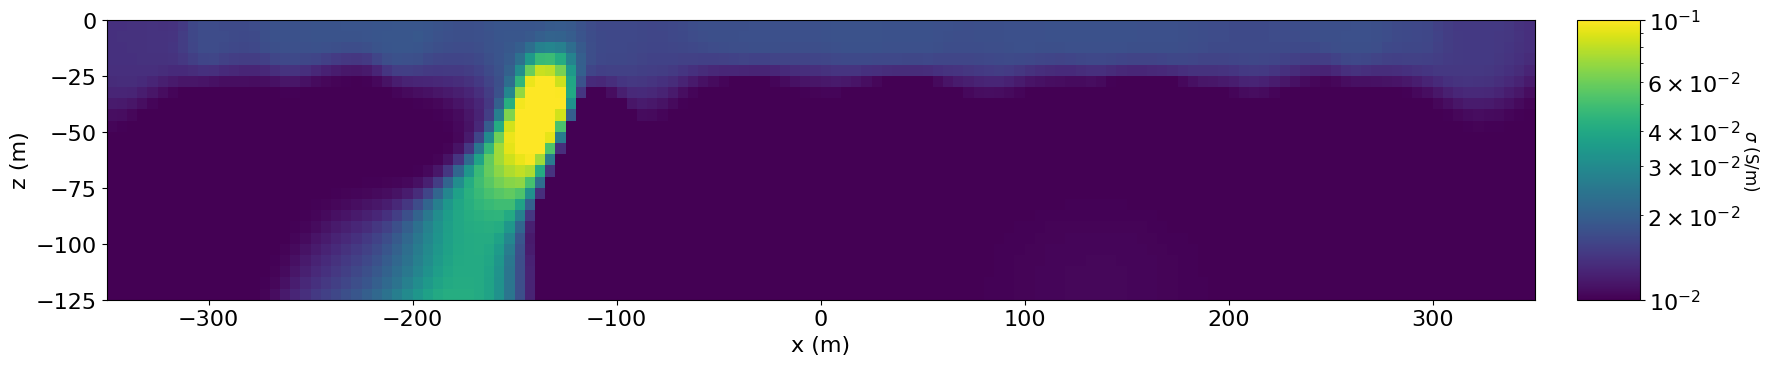

In [8]:
simpeg_inversion([0,1,1])